In [24]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

%matplotlib inline

In [27]:
def set_zoom(ax, ref_layer, buffer = 0):
    '''Sets the zoom of a map to the extent of the reference layer.
    ax is a matplotlib axis used for plotting a map, ref_layer is a geodataframe, buffer is an additional margin around 
    the extent of the reference layer (in units of the CRS of the reference layer).'''
    minx, miny, maxx, maxy = ref_layer.total_bounds
    minx -= buffer
    maxx += buffer
    miny -= buffer
    maxy += buffer
    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

### KMeans Clustering of LWR Coefficient Results and IMD Ranking of MSOAs

In [22]:
# read in data
results_coefs = pd.read_csv('results_lwr02_coefs.csv', index_col = 0)
with open('../90 Data/compiled secondary data/msoas', 'rb') as infile:
    msoas = pickle.load(infile)
with open('../90 Data/compiled secondary data/londonrail', 'rb') as infile:
    londonrail = pickle.load(infile)
with open('../90 Data/compiled secondary data/londontube', 'rb') as infile:
    londontube = pickle.load(infile)
with open('../90 Data/compiled secondary data/imd_msoa', 'rb') as infile:
    imd_msoa = pickle.load(infile)

In [45]:
# prepare data for kmeans clustering
kmeans_data = results_coefs.loc[:,['1','dv_local_mean','dist_bus','dist_nationalrail','dist_tube','dist_walking']].join(imd_msoa['Index of Multiple Deprivation (IMD) Rank'])
kmeans_data.columns = ['Intercept', 'DV Local Mean', 'Bus km', 'National Rail km', 'Tube km', 'Walking km', 'IMD Rank']
kmeans_data_standardised = StandardScaler().fit_transform(kmeans_data)

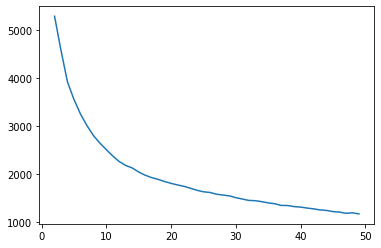

In [10]:
# identify suitable value for k
n_clusters = [i+2 for i in range(48)]
inertias = []
for i in n_clusters:
    inertias.append(KMeans(i, random_state = 1000).fit(kmeans_data_standardised).inertia_)
plt.plot(n_clusters, inertias)

In [46]:
# carry out KMeans clustering
n_clusters = 6
kmeans1 = KMeans(n_clusters, random_state = 6881).fit(kmeans_data_standardised)
# join clustering labels to raw data
kmeans_data['kmeans_cluster_' + str(n_clusters)] = kmeans1.labels_

(503574.18796895276, 561956.6879520521, 155850.7979227482, 200933.60890773044)

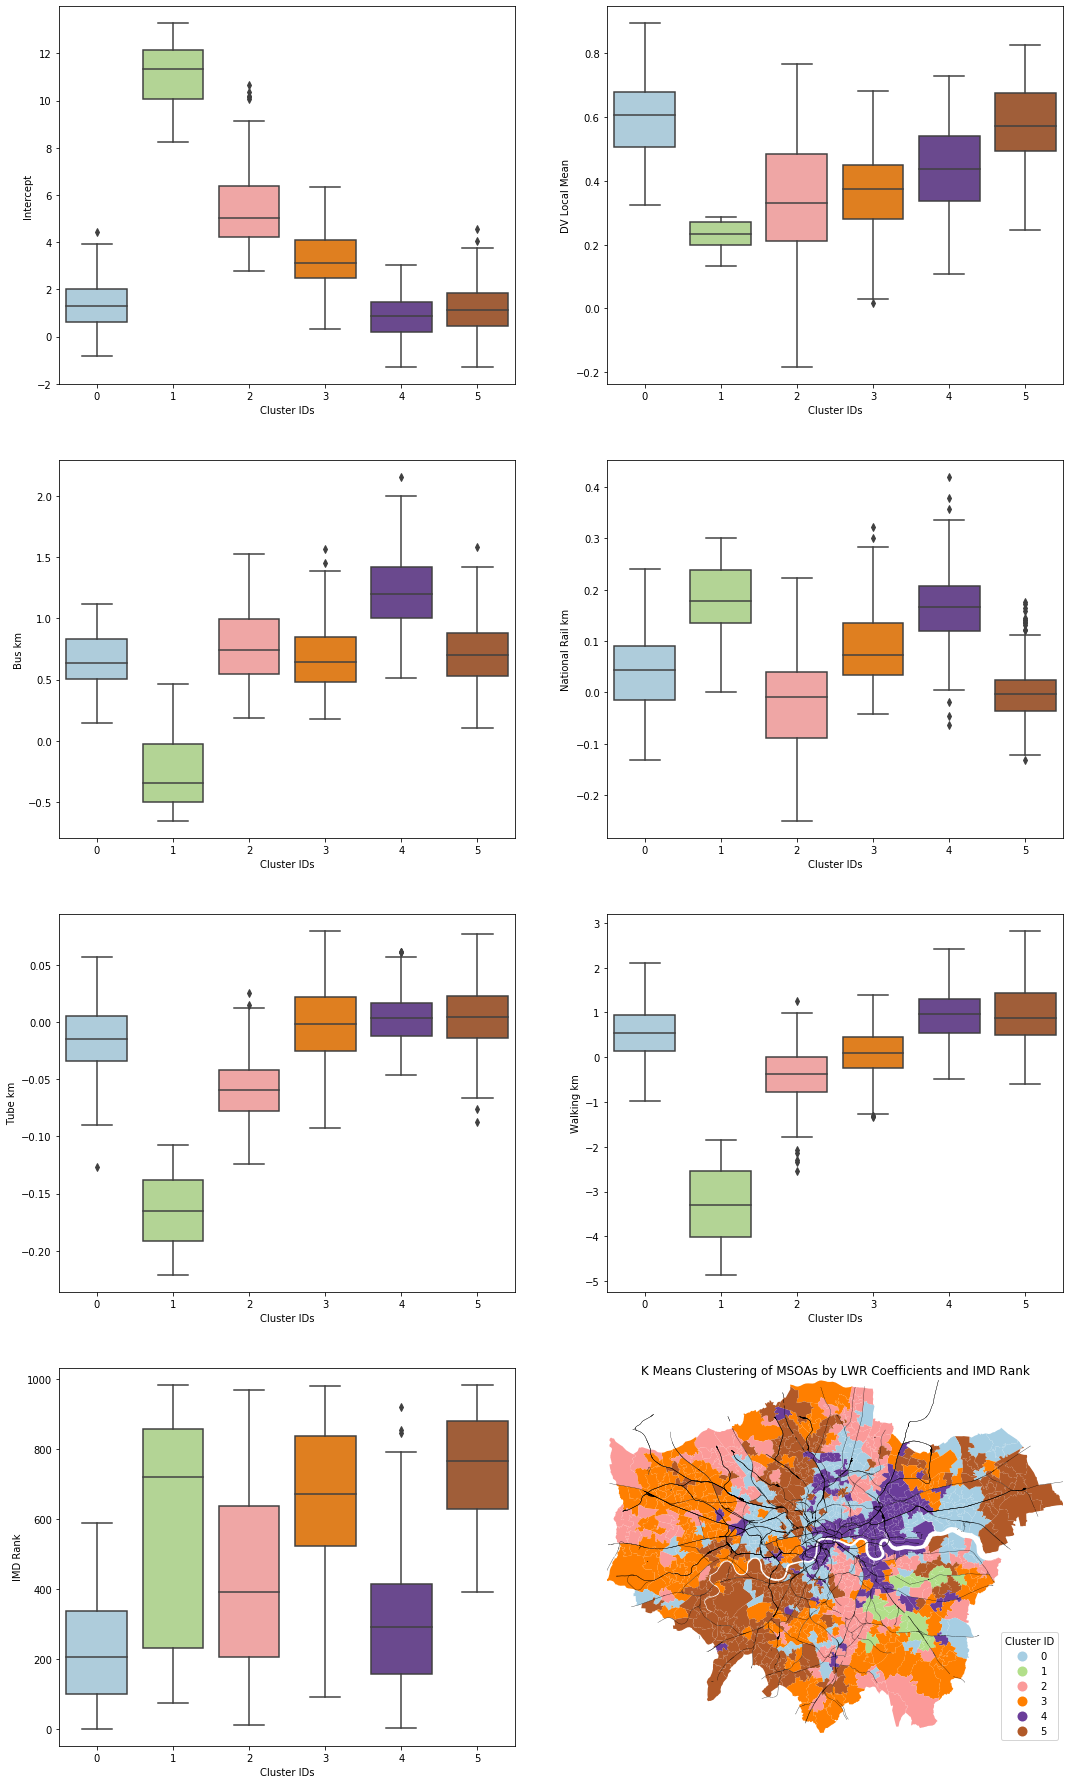

In [47]:
# set colormaps
colormap = []
colors = plt.cm.Paired(np.linspace(0, 1, n_clusters)) # generate colours used in mapping
for c in colors: # convert colours to hex format
    colormap.append(matplotlib.colors.to_hex(c))

# plot data
fig01 = plt.figure(figsize = (18,32))

# boxplots
i = 1
for column in kmeans_data.columns[:-1]:
    ax01 = fig01.add_subplot(4,2,i)
    with sns.color_palette(colormap):
        ax01 = sns.boxplot(x = 'kmeans_cluster_' + str(n_clusters), y = column, data = kmeans_data)
    ax01.set_xlabel('Cluster IDs')
    ax01.set_ylabel(column)
    i += 1

# clustering map
ax01_08 = fig01.add_subplot(4,2,8)
set_zoom(ax01_08, msoas)
msoas.join(kmeans_data).plot(column = 'kmeans_cluster_' + str(n_clusters), ax = ax01_08, cmap = 'Paired', categorical = True, legend = True)
londontube.plot(color = 'black', linewidth = .3, ax = ax01_08)
londonrail.plot(color = 'black', linewidth = .3, ax = ax01_08)
legend01_08 = ax01_08.get_legend()
legend01_08.set_bbox_to_anchor((1,.3))
legend01_08.set_title('Cluster ID')
plt.title('K Means Clustering of MSOAs by LWR Coefficients and IMD Rank')
plt.axis('off')